# Classification of handwritten digits with a neural network

## Install Cuda Toolkit 12.3 and Drivers for GPU usage for Tensorflow<=2.10.x

In [ ]:
# Coda drivers for GPU usage (Nvidia GTX 3050 TI)
# nvidia-smi # Nvidia driver
# https://developer.nvidia.com/cuda-downloads
# Check for CUDA paths:
echo $LD_LIBRARY_PATH
# Temporarily delete them:
# unset LD_LIBRARY_PATH

# CUDA Toolkit Installer
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.1-1_all.deb
sudo dpkg -i cuda-keyring_1.1-1_all.deb
sudo apt-get update
sudo apt-get -y install cuda-toolkit-12-3

# Install open kernel module and drivers:
sudo apt-get install -y nvidia-kernel-open-545
sudo apt-get install -y cuda-drivers-545


## Install cuDNN 8.9.2 (NVIDIA CUDA Deep Neural Network library) for Tensorflow<=2.10.x

In [ ]:
wget https://developer.download.nvidia.com/compute/cudnn/8.9.2/local_installers/cudnn-local-repo-ubuntu2204-8.9.2_1.0-1_amd64.deb
sudo dpkg -i cudnn-local-repo-ubuntu2204-8.9.2_1.0-1_amd64.deb
sudo cp /var/cudnn-local-repo-ubuntu2204-8.9.2/cudnn-*-keyring.gpg /usr/share/keyrings/ # gpg key
sudo apt update
sudo apt install libcudnn8 libcudnn8-dev libcudnn8-doc

# With conda
# conda activate createart
# conda install nvidia::cudnn cuda-version=12.3

## Create conda environment with specified libraries

In [ ]:
conda create -n createart python=3.10 # Tensorflow for python<=3.10.x 
conda activate createart
# conda list
# python --version

In [ ]:
# Set GPU mode to power mode:
sudo nvidia-smi -pm 1

# conda install python=3.10 # wegen ensporflow
# conda install -c conda-forge wget=2.2.0
pip install opencv-python wget ipykernel
pip install tf-keras-vis==0.8.7
pip install tensorflow==2.20.0 [2.20.0-cuda] # for GPU usage
# pip install tensorflow==2.20.0 # CPU usage
conda install -c conda-forge -c defaults scikit-learn==1.7.2 Pillow==12.0.0 matplotlib==3.10.7
conda install -c conda-forge -c defaults scipy==1.11.0 imutils==0.5.4 jupyter==1.0.0 numpy=1.26.4

python -m ipykernel install --user --name=createart --display-name "TensorFlow 2.20 (GPU)" # Select this kernel

## Load the MNIST dataset and examine its structure:

In [193]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

np.random.seed(329561404)

%matplotlib inline

In [194]:
# print("TensorFlow version:", tf.__version__)
# print("GPU available:", tf.config.list_physical_devices('GPU'))

In [195]:
# Load the MNIST dataset
data = keras.datasets.mnist # 28 x 28 images of handwritten digits between 0-9
(x_train, y_train), (x_test, y_test) = data.load_data() # Training and test data tuples

In [196]:
# Closer look at the data, inspecting its size, shape, and quantity
# type(x_train) numpy array; type(y_train) numpy ndarray

print(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test))

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


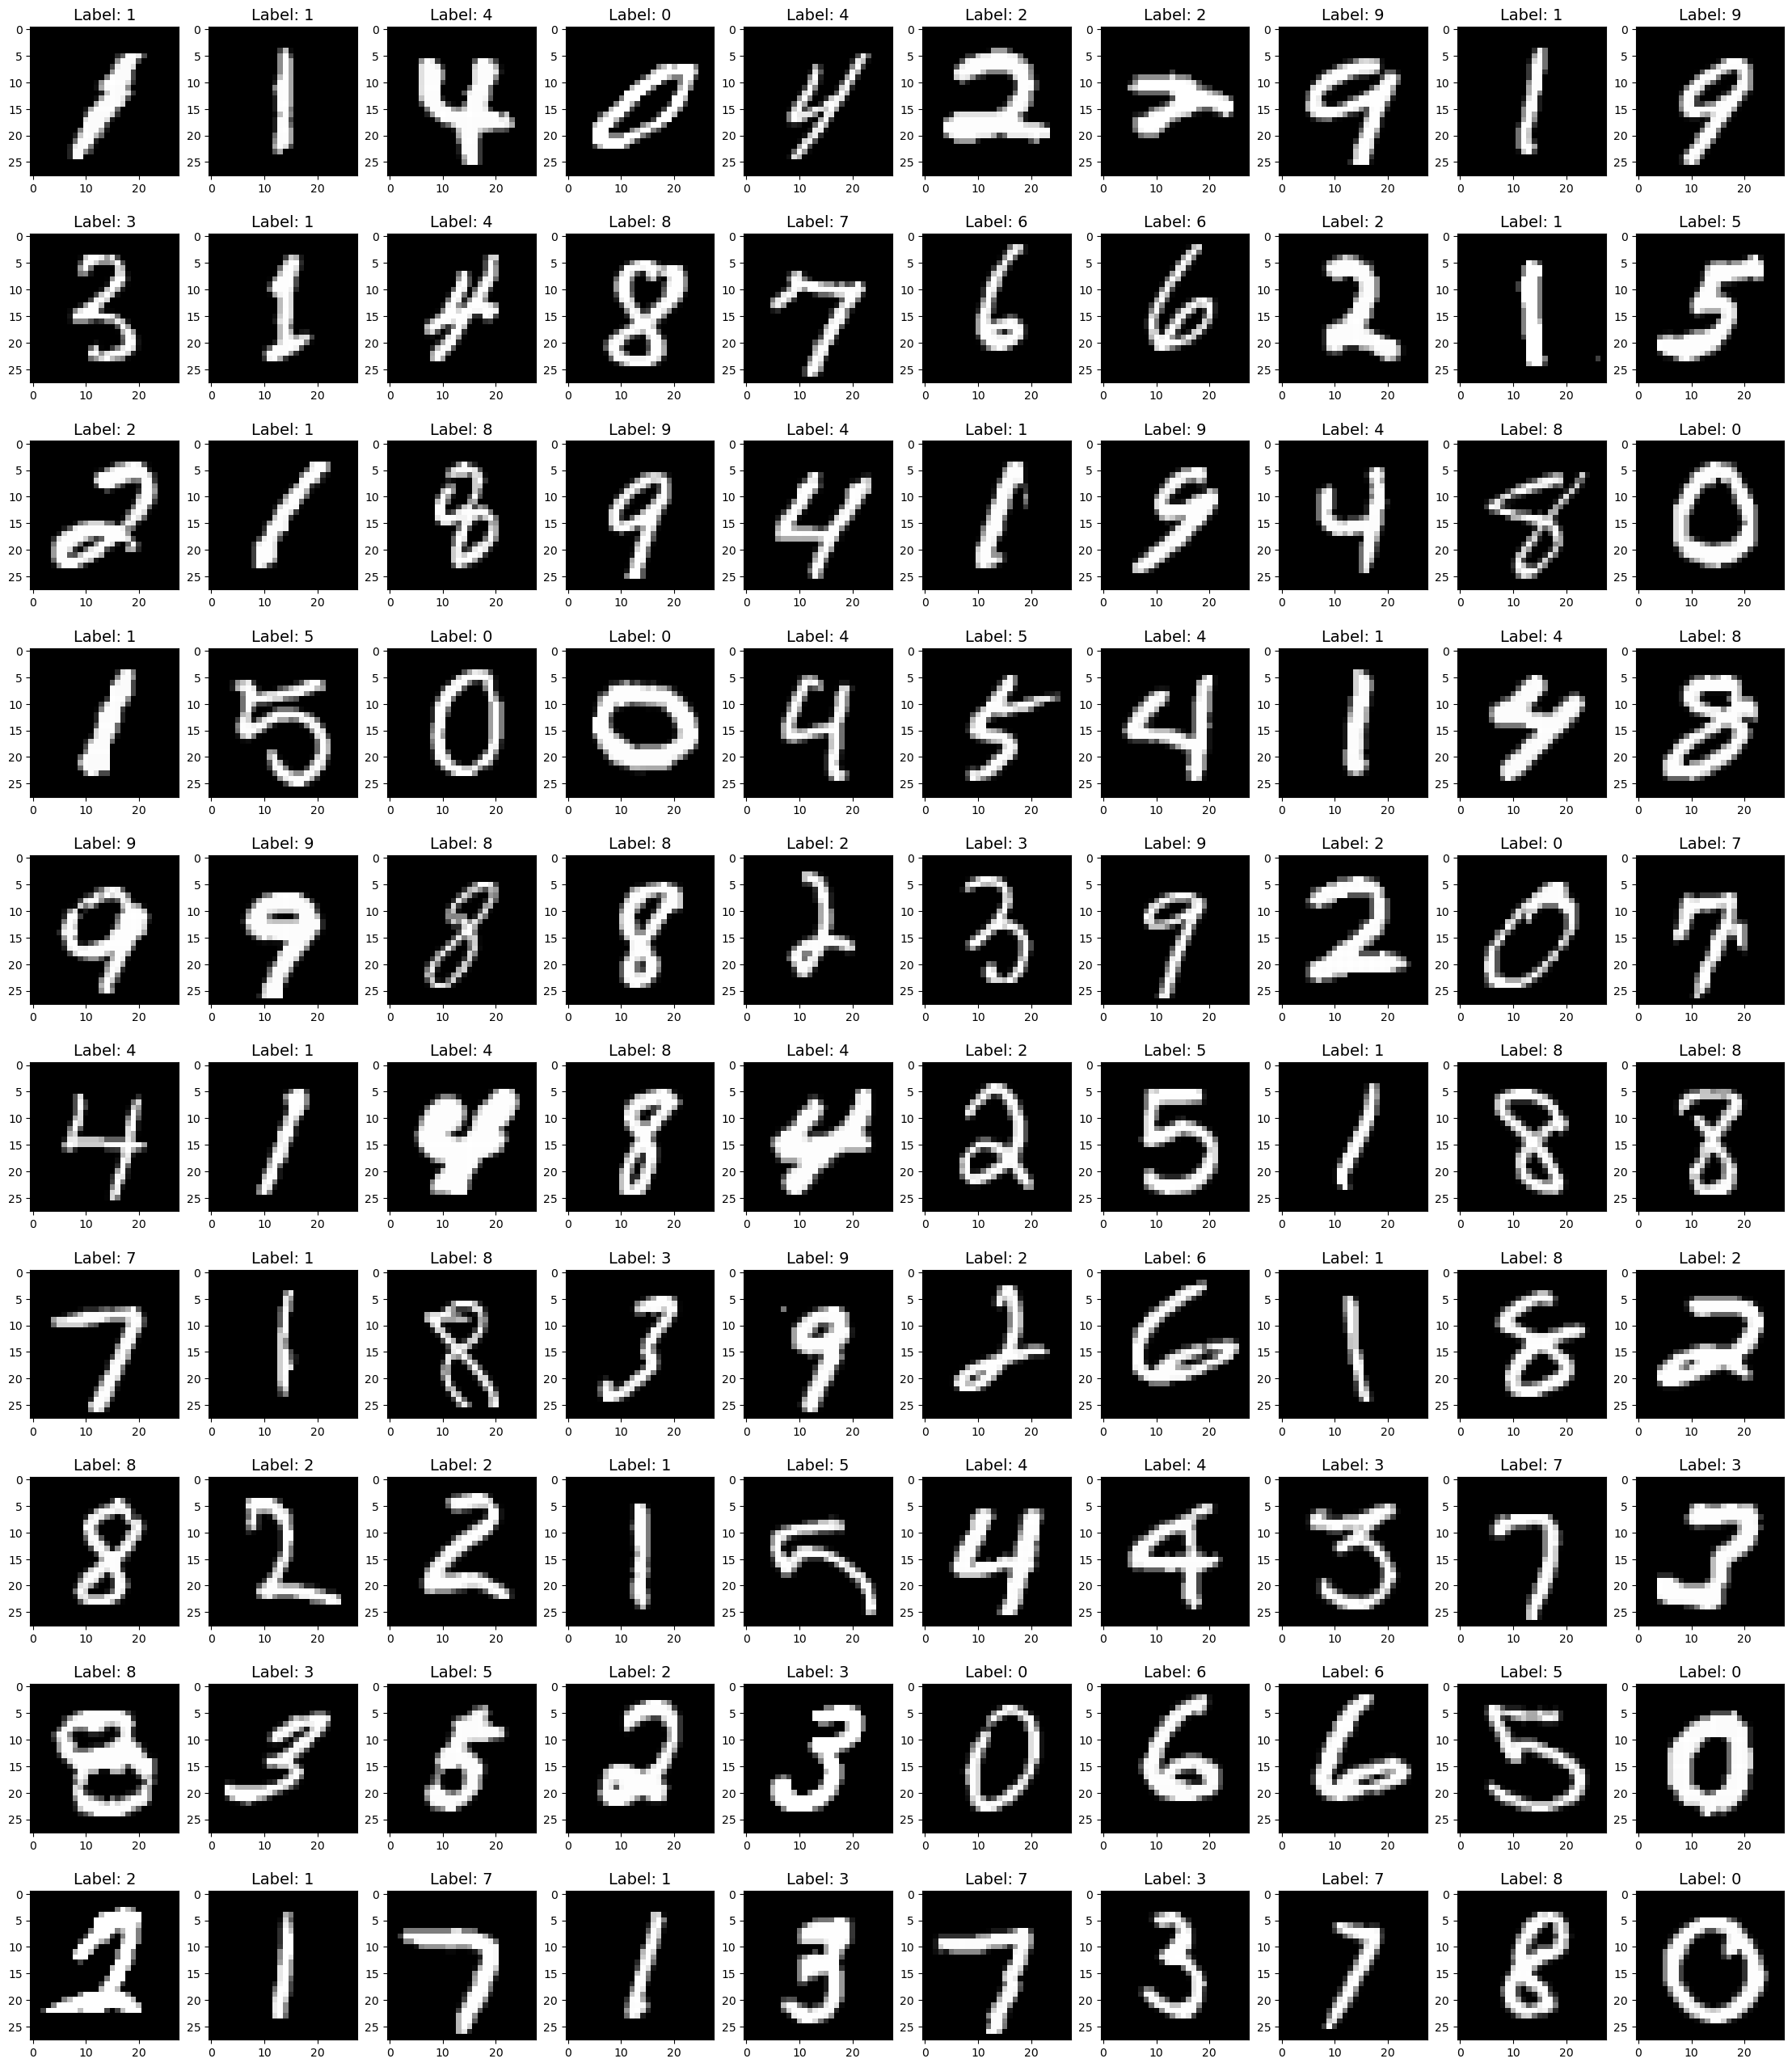

In [197]:
# View some random samples of the handwritten digits and observe the complexity of the images
fig, ax = plt.subplots(10, 10, figsize=(28,28))

for i in range(0, 10):
    for j in range(0, 10):
        rval = np.random.randint(low=0, high=x_train.shape[0], size=1, dtype=int)
        sample = x_train[rval][0]
        ax[i,j].imshow(sample, cmap='gray')
        ax[i,j].set_title("Label: {}".format(y_train[rval][0]), fontsize=14)
fig.subplots_adjust(bottom=0.05, top=0.95)
plt.show()

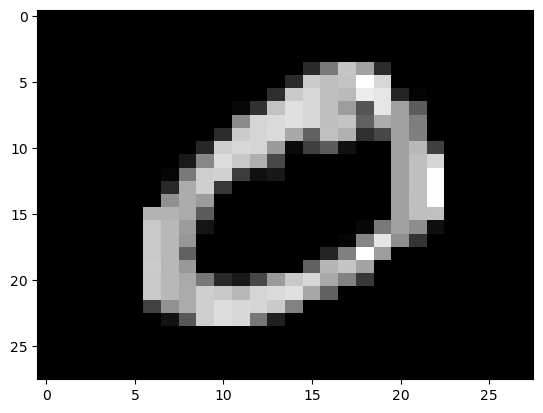

In [220]:
fig = plt.imshow(x_train[1], cmap=plt.get_cmap('gray'), aspect='auto')
plt.show(fig)
# print(y_train[1])
# print(x_train[1])

## Prepare the MNIST dataset for training

In [199]:
# Ensure the format or shape of the data is appropriate for input into your model. One-hot-encoding is needed for the labels.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(y_test[1:10])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [200]:
# Ensure data types are correct and that data is normalized.
# np.max(x_train[1]) = 255

# Normalize gray values:
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# Reshape arrays for network layerwise input:
# x_train = x_train.reshape(np.shape(x_train)[0], -1))
# x_test = x_test.reshape(np.shape(x_test)[0], -1)) # Or use a flatten layer
# print(np.shape(x_train.reshape(np.shape(x_train)[0], -1))): (60000, 784)

# Create a Convolutional Neural Network

In [203]:
cnn_model = Sequential()

# Two convolution layers (kernel size 3x3):
cnn_model.add(InputLayer(shape=(28,28,1))) # Input dimensions of 28 x 28 x 1
cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate = 0.2)) # Reduction of overfitting

cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(rate = 0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation="relu"))
cnn_model.add(Dropout(rate = 0.5))

cnn_model.add(Dense(units=10, activation="softmax")) # Softmax activation function for class probabilities
    
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) # sparse_categorical_crossentropy
# Monitor Validation Accuracy during the training process

In [204]:
cnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,922 (480.16 KB)

 Trainable params: 122,922 (480.16 KB)

 Non-trainable params: 0 (0.00 B)

In [205]:
# Train this CNN on the MNIST dataset.
cnn_model.fit(x=x_train, y=y_train, epochs=20, batch_size=32, validation_split = 0.05)
# At least 5 epochs, using a batch size of 32, accuracy of least 98% on the test data

# nvidia-smi -l 2 # Monitor GPU usage

Epoch 1/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9086 - loss: 0.2989 - val_accuracy: 0.9863 - val_loss: 0.0559
Epoch 2/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9653 - loss: 0.1148 - val_accuracy: 0.9893 - val_loss: 0.0442
Epoch 3/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9732 - loss: 0.0894 - val_accuracy: 0.9907 - val_loss: 0.0398
Epoch 4/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9774 - loss: 0.0750 - val_accuracy: 0.9910 - val_loss: 0.0370
Epoch 5/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9806 - loss: 0.0655 - val_accuracy: 0.9910 - val_loss: 0.0366
Epoch 6/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9817 - loss: 0.0591 - val_accuracy: 0.9933 - val_loss: 0.0335
Epoch 7/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9832 - loss: 0.0541 - val_accuracy: 0.9923 - val_loss: 0.0342
Epoch 8/20
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9833 - loss: 0.0527 - 

In [206]:
# Test the network on test data
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)
print("Test Loss: {0:1.5f}, Test Accuracy: {1:1.5f}".format(val_accuracy, val_loss))

# The expected accuracy of your model should be at least 98% on the test data
# loss: 0.0254923477768898 and accuracy: 0.9923999905586243 for the test data

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9919 - loss: 0.0264
Test Loss: 0.02549, Test Accuracy: 0.99240


## Evaluation of the test results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


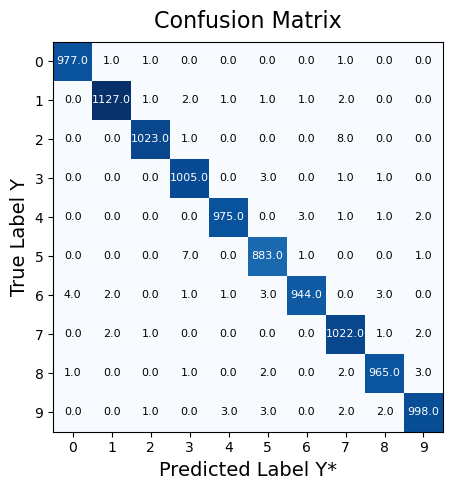

In [207]:
# Generate a confusion matrix:
y_test_pred = cnn_model.predict(x_test)
y_test_classes = np.argmax(y_test, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Confusion matrix of true and predicted labels from the test data (10x10 contingency table):
conf_matrix = np.zeros((10,10))
labels = np.linspace(0,9,10)

for i in range(0,len(x_test)):
    conf_matrix[y_test_classes[i],y_test_pred_classes[i]] += 1

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(conf_matrix, cmap="Blues")
ax.set_xlabel("Predicted Label Y*", fontsize = 14)
ax.set_ylabel("True Label Y", fontsize = 14)
ax.set_title("Confusion Matrix", pad=10, fontsize = 16)

ax.set_xticks(labels, labels=[0,1,2,3,4,5,6,7,8,9],rotation=0)
ax.set_yticks(labels, labels=[0,1,2,3,4,5,6,7,8,9], rotation=0)

for i in range(len(labels)):
    for j in range(len(labels)):
        if i==j:
            ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="w", fontsize = 8)
        else:
            ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="k", fontsize = 8)
fig.tight_layout()
plt.show()



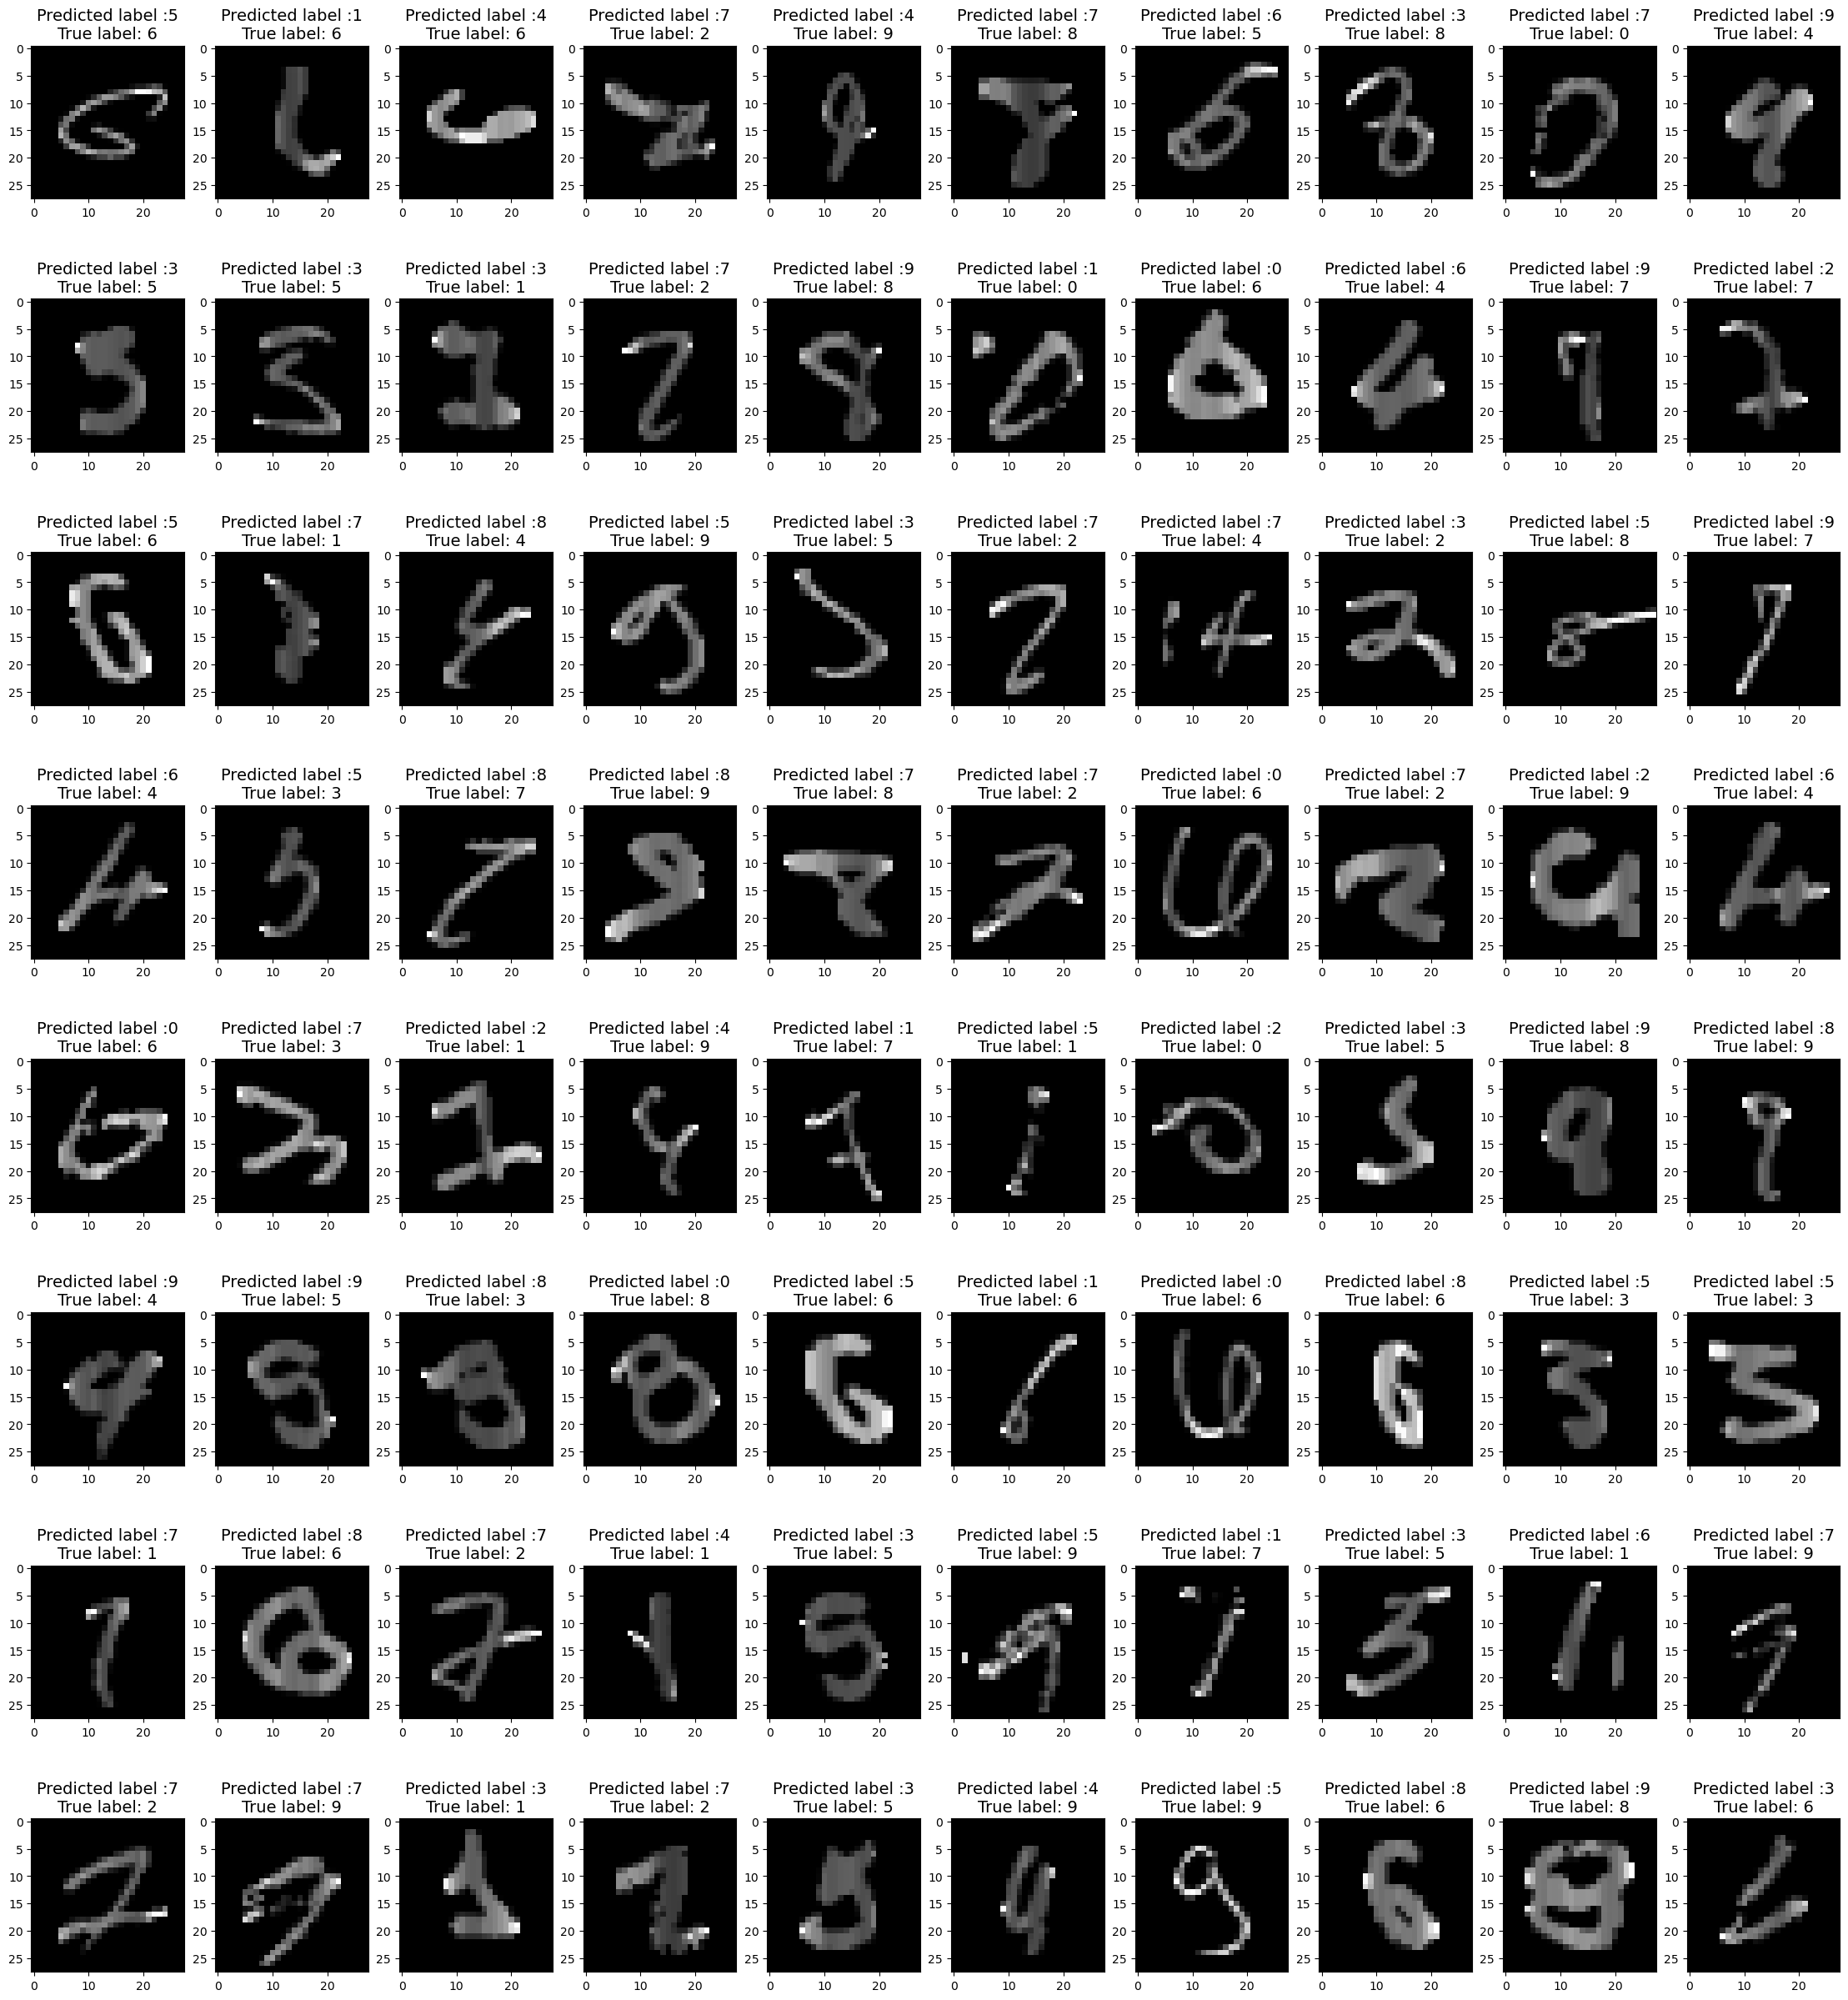

In [208]:
# Investigate some misclassifications:

err = (y_test_pred_classes - y_test_classes != 0) # 84 misclassifications
y_test_pred_classes_err = y_test_pred_classes[err]
y_test_pred_err = y_test_pred[err]
y_test_classes_err = y_test_classes[err]
x_test_err = x_test[err]

y_test_pred_err_prob = np.max(y_test_pred_err, axis=1)
true_probability_for_err = y_test_pred_err[np.linspace(0,len(y_test_classes_err)-1,len(y_test_classes_err), dtype=int),y_test_classes_err]
diff_err = y_test_pred_err_prob - true_probability_for_err
diff_err_sorted = np.argsort(diff_err)

# Misclassified digits with highest probability difference:
fig, ax = plt.subplots(8, 10, figsize=(28,28))

for i in range(0, 8):
    for j in range(0, 10):
        index = diff_err_sorted[len(diff_err_sorted)- 1 - i * 10 - j]
        sample = x_test_err[index].reshape(28,28)
        pred_label = y_test_pred_classes_err[index]
        true_label = y_test_classes_err[index]
        ax[i,j].imshow(sample, cmap="gray")
        ax[i,j].set_title("Predicted label :{}\nTrue label: {}".format(pred_label, true_label), fontsize=14)
fig.subplots_adjust(bottom=0.10, top=0.95)
plt.show()

In [219]:
training_loss, training_accuracy, test_loss, test_accuracy = (np.zeros(30), np.zeros(30), np.zeros(30),np.zeros(30))

for i in range(0,30):
    cnn_model = Sequential()
    cnn_model.add(InputLayer(shape=(28,28,1)))
    cnn_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(Dropout(rate = 0.1)) # Changed dropout rate
    cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
    cnn_model.add(MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(Dropout(rate = 0.1)) # Changed dropout rate
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=128, activation="relu"))
    cnn_model.add(Dropout(rate = 0.25)) # Changed dropout rate
    cnn_model.add(Dense(units=10, activation="softmax"))
    cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    cnn_model.fit(x=x_train, y=y_train, epochs=i, batch_size=32, validation_split = 0.05)
    training_loss[i], training_accuracy[i] = cnn_model.evaluate(x_train, y_train)
    test_loss[i], test_accuracy[i] = cnn_model.evaluate(x_test, y_test)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1028 - loss: 2.3048
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1062 - loss: 2.3045
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9327 - loss: 0.2154 - val_accuracy: 0.9857 - val_loss: 0.0525
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9820 - loss: 0.0585
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9805 - loss: 0.0579
Epoch 1/2
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9346 - loss: 0.2065 - val_accuracy: 0.9890 - val_loss: 0.0482
Epoch 2/2
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9764 - loss: 0.0783 - val_accuracy: 0.9910 - val_loss: 0.0424
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9874 - loss: 0.0407
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9854 - loss: 0.0433
Epoch 1/3
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9328 - loss: 0.2156 - val_accuracy: 0.9867 - val_loss: 0.0531
Epoch 2/3
1782/1782 ━━━━━━━━━━━━━━━

(0.0, 0.2)

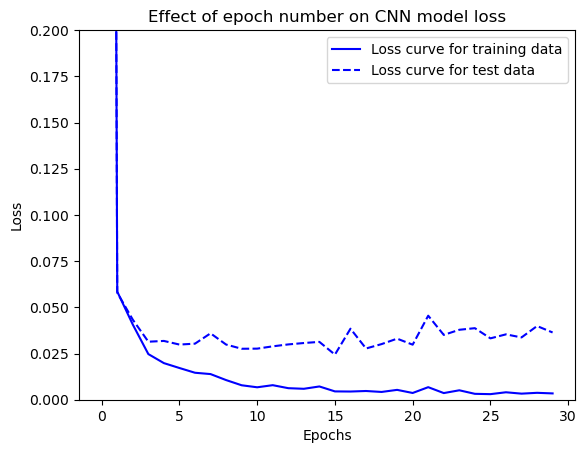

In [222]:
# Plot loss curves:
epochs = np.linspace(0,29,30)
plt.plot(epochs, training_loss, "b-", label="Loss curve for training data")
plt.plot(epochs, test_loss, 'b--', label="Loss curve for test data")
plt.title("Effect of epoch number on CNN model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.ylim([0.00,0.20])

(0.95, 1.0)

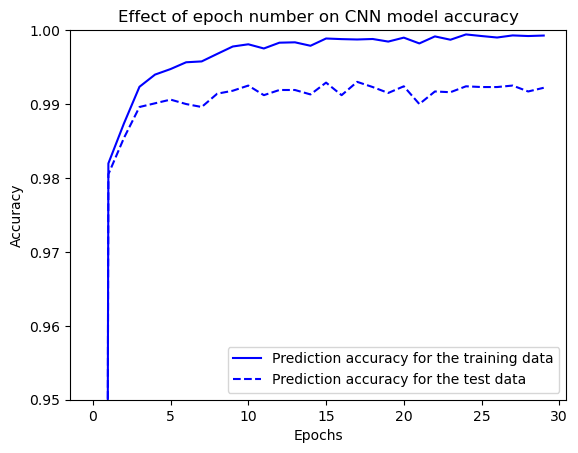

In [223]:
# Plot validation accuracy curves:

epochs = np.linspace(0,29,30)
plt.plot(epochs, training_accuracy, "b-", label="Prediction accuracy for the training data")
plt.plot(epochs, test_accuracy, 'b--', label="Prediction accuracy for the test data")
plt.title("Effect of epoch number on CNN model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([0.95,1.00])
# Overfitting is reduced due to dropout layer